# EEG ChildMind Dataset Analysis

This notebook takes data from ChildMind and finds correlations between neural spectral parameters ratio measures and age.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm, colors, colorbar, rcParams
import pandas as pd
import numpy as np
from numpy.linalg import LinAlgError
from scipy.stats import pearsonr, spearmanr
import csv
import mne
import seaborn as sns
sns.set_context('poster')
pd.set_option('display.max_columns', 500)

from fooof import FOOOF, FOOOFGroup
from fooof.analysis import *
from fooof.synth import *
from fooof.data import FOOOFResults
from fooof.funcs import average_fg
from fooof.bands import Bands

from ratios import *
from analysis import *
from settings import *

## Import Data

Here we import power spectra and select channel clusters

In [2]:
# Open Power spectrum
data = pd.read_csv("../dat/MIPDB_PublicFile.csv")

In [3]:
# Read in list of channel names that are kept in reduced 111 montage
with open('../dat/chans111.csv', 'r') as csv_file:
    reader = csv.reader(csv_file)
    ch_labels = list(reader)[0]
    
# Read montage, reduced to 111 channel selection
montage = mne.channels.read_montage('GSN-HydroCel-129', ch_names=ch_labels)

In [4]:
all_chans = mne.pick_channels(montage.ch_names,[])

In [5]:
# Define a channel cluster of interest
ch_cluster_parietal = ['E71', 'E76', 'E70', 'E75', 'E83']
ch_cluster_central = ['E7','E106', 'E31', 'Cz', 'E80']
ch_cluster_frontal = ['E15', 'E18', 'E16', 'E10', 'E11']

# Get the indices of the channels of interest
ch_inds_parietal = mne.pick_channels(montage.ch_names, ch_cluster_parietal)
ch_inds_central = mne.pick_channels(montage.ch_names, ch_cluster_central)
ch_inds_frontal = mne.pick_channels(montage.ch_names, ch_cluster_frontal)

In [6]:
fron = np.zeros(111)
cen = np.zeros(111)
par = np.zeros(111)
fron[ch_inds_frontal] = 1
cen[ch_inds_central] = 1
par[ch_inds_parietal] = 1

<Figure size 720x576 with 0 Axes>

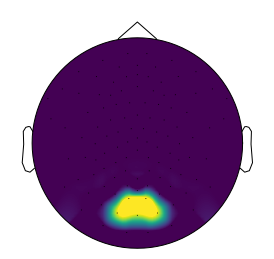

In [60]:
# Create the info structure needed by MNE
from matplotlib.pyplot import figure
#import marplotlib as mpl
rcParams['figure.figsize'] = 6, 4
figure(num=None, figsize=(10, 8))
plt.tight_layout()
info = mne.create_info(ch_labels, 500, 'eeg', montage)

# Create the MNE Raw data object
raw = mne.io.RawArray(np.zeros([111, 1]), info, verbose=False)

fig,ax = plt.subplots()


#ax.set_title("Frontal Region")
# ax.set_label(["E15, E18, E16, E10, E11"])
# mne.viz.plot_topomap(fron, raw.info, cmap=cm.viridis, contours=0, axes=ax)

# ax.set_title("Central Region")
# mne.viz.plot_topomap(cen, raw.info, cmap=cm.viridis, contours=0, axes=ax)

# ax.set_title("Parietal Region")
mne.viz.plot_topomap(par, raw.info, cmap=cm.viridis, contours=0, axes=ax)

fig.savefig('../figures/parietal_topo.png', dpi=700);

In [20]:
fron

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Correlation between Parameters and Theta Beta Ratio

In [6]:
df = get_all_data(data, all_chans)
df.to_csv("../dat/child_mind_data")
df

FileNotFound or ValueError:  A00052593
FileNotFound or ValueError:  A00053398
IndexError:  A00053480
FileNotFound or ValueError:  A00054122
IndexError:  A00054239
FileNotFound or ValueError:  A00054359
FileNotFound or ValueError:  A00054469
FileNotFound or ValueError:  A00054488
FileNotFound or ValueError:  A00054666
FileNotFound or ValueError:  A00054836
FileNotFound or ValueError:  A00054866
FileNotFound or ValueError:  A00055623
FileNotFound or ValueError:  A00055628
FileNotFound or ValueError:  A00055801
FileNotFound or ValueError:  A00055923
FileNotFound or ValueError:  A00056116
FileNotFound or ValueError:  A00056158
LinAlgError:  A00056428
FileNotFound or ValueError:  A00056640
FileNotFound or ValueError:  A00056716
FileNotFound or ValueError:  A00056733
FileNotFound or ValueError:  A00056913
FileNotFound or ValueError:  A00056990
FileNotFound or ValueError:  A00057135
FileNotFound or ValueError:  A00062029
FileNotFound or ValueError:  A00062055
FileNotFound or ValueError:  A000

,ABR,Age,Alpha_BW,Alpha_CF,Alpha_PW,Beta_BW,Beta_CF,Beta_PW,Chan_ID,Exp,Off,Subj_ID,TAR,TBR,Theta_BW,Theta_CF,Theta_PW
0,14.927507,10.0,2.576849,10.435396,0.632860,0.651490,21.504787,0.438832,0.0,1.860829,1.198277,A00051826,1.650478,14.927507,2.465400,7.168822,0.620085
1,16.475258,10.0,2.487412,10.419192,0.437804,0.816660,21.546040,0.419847,1.0,1.920281,1.666018,A00051826,2.220317,16.475258,2.423398,7.288344,0.636498
2,16.790004,10.0,3.221616,10.123551,0.563381,1.600415,23.907194,0.434605,2.0,1.924418,1.434980,A00051826,2.066784,16.790004,0.500000,7.747992,0.578458
3,16.768082,10.0,3.119242,10.098946,0.542737,1.178912,23.735743,0.323136,3.0,1.992965,1.534520,A00051826,2.016178,16.768082,1.427005,6.481169,0.464667
4,21.750502,10.0,0.500000,10.267526,0.659122,0.500000,23.683487,0.266571,4.0,2.022430,1.588774,A00051826,2.289902,21.750502,1.597491,6.847909,0.537066
5,20.606952,10.0,3.093522,10.269264,0.606551,0.926288,15.122875,0.262554,5.0,2.049553,1.686557,A00051826,2.040675,20.606952,1.651050,6.615213,0.486021
6,23.949520,10.0,2.962543,10.158780,0.620734,0.907721,15.065078,0.259223,6.0,2.007281,1.527516,A00051826,2.304348,23.949520,1.327306,6.849875,0.638814
7,13.983302,10.0,3.117171,10.276872,0.646379,0.706157,21.511848,0.455105,7.0,1.861614,1.236429,A00051826,1.635796,13.983302,2.155361,6.774232,0.581870
8,16.899240,10.0,2.813007,10.048198,0.533521,0.500000,23.673429,0.329134,8.0,1.875105,1.479176,A00051826,2.099608,16.899240,1.566126,6.831617,0.507819
9,16.394786,10.0,2.903103,10.223956,0.519875,1.080035,23.768848,0.294196,9.0,1.890382,1.446523,A00051826,2.038738,16.394786,2.077368,6.705398,0.415047


In [9]:
len(df.Subj_ID.unique())

97

In [53]:
sns.heatmap?

In [7]:
df = pd.read_csv("../dat/child_mind_data")

In [8]:
ages = df["Age"]
subs = df.Subj_ID

# All Channels

### TBR:

### Global

SpearmanrResult(correlation=-0.010486193085193732, pvalue=0.47268733756185755)
SpearmanrResult(correlation=-0.08412540922672725, pvalue=9.209100975779661e-18)
SpearmanrResult(correlation=0.3530616823631805, pvalue=8.531685635839347e-138)
SpearmanrResult(correlation=-0.2550372798950505, pvalue=9.561665489959044e-154)
SpearmanrResult(correlation=0.2264730110771764, pvalue=1.2234849674201136e-55)
SpearmanrResult(correlation=-0.1152939026308864, pvalue=4.831251619175502e-32)
SpearmanrResult(correlation=0.7284222555134583, pvalue=0.0)
SpearmanrResult(correlation=0.6730206898089981, pvalue=0.0)
SpearmanrResult(correlation=-0.6089315099546881, pvalue=0.0)


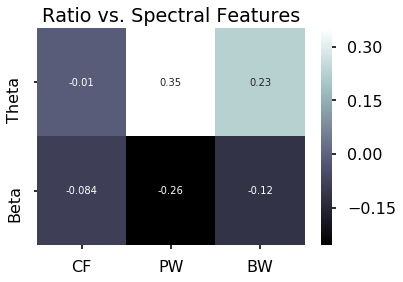

The corr of TBR to Exp is 0.73
The corr of TBR to Off is 0.67
The corr of TBR to Age is -0.61


<Figure size 432x288 with 0 Axes>

In [9]:
tbr_per, tbr_ap = param_ratio_corr(df, "TBR", all_chans, func=nan_corr_spearman)
plot_param_ratio_corr(tbr_per, y_labels=["Theta","Beta"],save_fig=True, file_name="TBR_corrs")
print_aperiodic_correlation("TBR", tbr_ap)

### Frontal

SpearmanrResult(correlation=0.026537403075265326, pvalue=0.699494415794208)
SpearmanrResult(correlation=-0.07664352112384894, pvalue=0.09663649271896395)
SpearmanrResult(correlation=0.41812649424038256, pvalue=1.8258465014196318e-10)
SpearmanrResult(correlation=-0.32689492168568157, pvalue=3.427048433555829e-13)
SpearmanrResult(correlation=0.16438772249354452, pvalue=0.01607981197277514)
SpearmanrResult(correlation=-0.12406209496500632, pvalue=0.007023475825915103)
SpearmanrResult(correlation=0.7123548301930058, pvalue=2.7105688814659762e-76)
SpearmanrResult(correlation=0.6547698162506036, pvalue=1.0492076011873656e-60)
SpearmanrResult(correlation=-0.5704264478434629, pvalue=3.3000472047927283e-43)


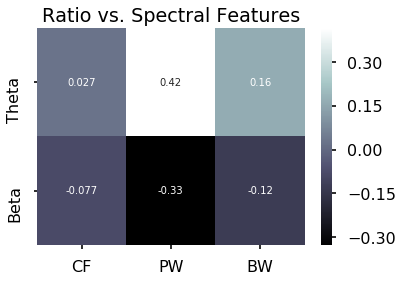

The corr of TBR to Exp is 0.71
The corr of TBR to Off is 0.65
The corr of TBR to Age is -0.57


<Figure size 432x288 with 0 Axes>

In [10]:
tbr_per, tbr_ap = param_ratio_corr(df, "TBR", ch_inds_frontal, func=nan_corr_spearman)
plot_param_ratio_corr(tbr_per, y_labels=["Theta","Beta"],save_fig=True, file_name="TBR_corrs")
print_aperiodic_correlation("TBR", tbr_ap)

### Central

SpearmanrResult(correlation=-0.10506875544904609, pvalue=0.11604190409565704)
SpearmanrResult(correlation=-0.11630541433418815, pvalue=0.012847631817849894)
SpearmanrResult(correlation=0.3123019384745049, pvalue=1.7661116682993922e-06)
SpearmanrResult(correlation=-0.15259715440551158, pvalue=0.0010663657815791)
SpearmanrResult(correlation=0.2393037828155758, pvalue=0.00029195395804684)
SpearmanrResult(correlation=-0.13829546765586742, pvalue=0.0030508198431254286)
SpearmanrResult(correlation=0.7871623778262782, pvalue=1.3359844146248706e-102)
SpearmanrResult(correlation=0.7289061084704237, pvalue=7.5250488094932e-81)
SpearmanrResult(correlation=-0.6430942260735631, pvalue=1.7367703702374113e-57)


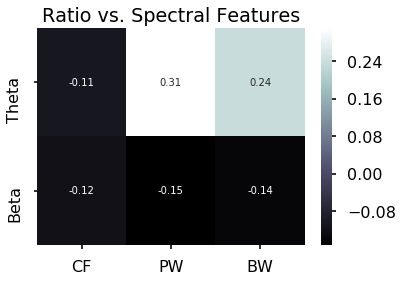

The corr of TBR to Exp is 0.79
The corr of TBR to Off is 0.73
The corr of TBR to Age is -0.64


<Figure size 432x288 with 0 Axes>

In [11]:
tbr_per, tbr_ap = param_ratio_corr(df, "TBR", ch_inds_central, func=nan_corr_spearman)
plot_param_ratio_corr(tbr_per, y_labels=["Theta","Beta"],save_fig=True, file_name="TBR_corrs")
print_aperiodic_correlation("TBR", tbr_ap)

### Parietal

SpearmanrResult(correlation=0.08497771479309094, pvalue=0.24372879963133426)
SpearmanrResult(correlation=-0.10340524354395912, pvalue=0.024973306072937847)
SpearmanrResult(correlation=0.3823581641713359, pvalue=5.211196491032835e-08)
SpearmanrResult(correlation=-0.35112176518911653, pvalue=4.40036051326251e-15)
SpearmanrResult(correlation=0.16786018183745507, pvalue=0.02061430284026363)
SpearmanrResult(correlation=-0.22995855708581273, pvalue=4.6600714809116796e-07)
SpearmanrResult(correlation=0.73808458370045, pvalue=1.024662051611738e-83)
SpearmanrResult(correlation=0.7349207244823109, pvalue=1.1739089289789453e-82)
SpearmanrResult(correlation=-0.6299785602500033, pvalue=1.901110886797472e-54)


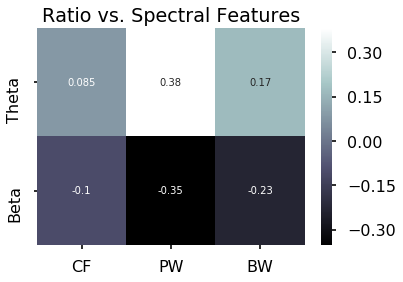

The corr of TBR to Exp is 0.74
The corr of TBR to Off is 0.73
The corr of TBR to Age is -0.63


<Figure size 432x288 with 0 Axes>

In [12]:
tbr_per, tbr_ap = param_ratio_corr(df, "TBR", ch_inds_parietal, func=nan_corr_spearman)
plot_param_ratio_corr(tbr_per, y_labels=["Theta","Beta"], save_fig=True, file_name="TBR_corrs")
print_aperiodic_correlation("TBR", tbr_ap)

### TAR

### Global

SpearmanrResult(correlation=-0.30848405210170265, pvalue=5.424493330385859e-104)
SpearmanrResult(correlation=-0.15321692161821468, pvalue=1.780477067599699e-55)
SpearmanrResult(correlation=-0.1835511070726774, pvalue=7.88907553254602e-37)
SpearmanrResult(correlation=-0.8937999814196274, pvalue=0.0)
SpearmanrResult(correlation=-0.006333730097578707, pvalue=0.664478921201644)
SpearmanrResult(correlation=-0.1988107378173101, pvalue=6.992287298970602e-93)
SpearmanrResult(correlation=0.15784972573852782, pvalue=1.4454128484509228e-60)
SpearmanrResult(correlation=0.13842843888327577, pvalue=7.317922091001838e-47)
SpearmanrResult(correlation=-0.3128364612419722, pvalue=3.111147788583773e-241)


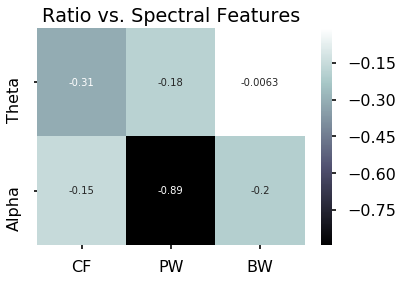

The corr of TAR to Exp is 0.16
The corr of TAR to Off is 0.14
The corr of TAR to Age is -0.31


<Figure size 432x288 with 0 Axes>

In [13]:
tar_per, tar_ap = param_ratio_corr(df, "TAR", all_chans, func=nan_corr_spearman)
plot_param_ratio_corr(tar_per, y_labels=["Theta","Alpha"],save_fig=True, file_name="TAR_corrs")
print_aperiodic_correlation("TAR", tar_ap)

### Frontal

SpearmanrResult(correlation=-0.4636022175216043, pvalue=8.422765096794262e-13)
SpearmanrResult(correlation=-0.12979168556383586, pvalue=0.005060729138703546)
SpearmanrResult(correlation=-0.23317221302166402, pvalue=0.0005848219912163295)
SpearmanrResult(correlation=-0.8950257081067664, pvalue=1.8426751392496986e-164)
SpearmanrResult(correlation=-0.0017046164311011172, pvalue=0.9802221828030346)
SpearmanrResult(correlation=-0.24698994194733312, pvalue=6.83187132491443e-08)
SpearmanrResult(correlation=0.19848142994034904, pvalue=1.0641588237105898e-05)
SpearmanrResult(correlation=0.2366374354815467, pvalue=1.3419221936657404e-07)
SpearmanrResult(correlation=-0.3339043374381472, pvalue=4.2751940700770107e-14)


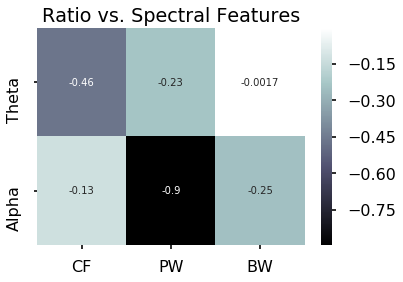

The corr of TAR to Exp is 0.20
The corr of TAR to Off is 0.24
The corr of TAR to Age is -0.33


<Figure size 432x288 with 0 Axes>

In [14]:
tar_per, tar_ap = param_ratio_corr(df, "TAR", ch_inds_frontal, func=nan_corr_spearman)
plot_param_ratio_corr(tar_per, y_labels=["Theta","Alpha"],save_fig=True, file_name="TAR_corrs")
print_aperiodic_correlation("TAR", tar_ap)

### Central

SpearmanrResult(correlation=-0.26974839272215534, pvalue=4.1324366298198126e-05)
SpearmanrResult(correlation=-0.07764886869930836, pvalue=0.09267666587933947)
SpearmanrResult(correlation=-0.12096291613990731, pvalue=0.07014189950157446)
SpearmanrResult(correlation=-0.8810670863058339, pvalue=2.8352708727118368e-154)
SpearmanrResult(correlation=0.08369387766569719, pvalue=0.21107639518379848)
SpearmanrResult(correlation=-0.2551180448007403, pvalue=2.0328674587657494e-08)
SpearmanrResult(correlation=0.2145619646138318, pvalue=2.04540465988157e-06)
SpearmanrResult(correlation=0.2937983626780307, pvalue=4.9532665214883735e-11)
SpearmanrResult(correlation=-0.3483127223314698, pvalue=3.635136386407677e-15)


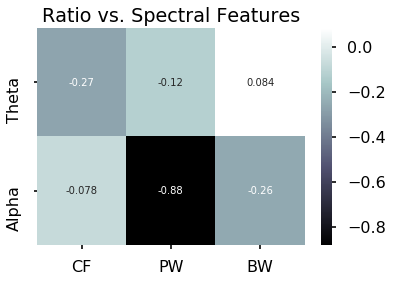

The corr of TAR to Exp is 0.21
The corr of TAR to Off is 0.29
The corr of TAR to Age is -0.35


<Figure size 432x288 with 0 Axes>

In [15]:
tar_per, tar_ap = param_ratio_corr(df, "TAR", ch_inds_central, func=nan_corr_spearman)
plot_param_ratio_corr(tar_per, y_labels=["Theta","Alpha"],save_fig=True, file_name="TAR_corrs")
print_aperiodic_correlation("TAR", tar_ap)

### Parietal

SpearmanrResult(correlation=-0.45068780152825355, pvalue=6.80484896619611e-11)
SpearmanrResult(correlation=-0.241065116076084, pvalue=1.1828572849059552e-07)
SpearmanrResult(correlation=-0.2636005371194129, pvalue=0.00023811686684219971)
SpearmanrResult(correlation=-0.894491238305682, pvalue=4.441097326124519e-166)
SpearmanrResult(correlation=-0.09115941767451813, pvalue=0.21098551882449945)
SpearmanrResult(correlation=-0.14540760843896247, pvalue=0.0015553077581978991)
SpearmanrResult(correlation=0.17700478300687067, pvalue=9.671214731021577e-05)
SpearmanrResult(correlation=0.19112821670232943, pvalue=2.4932031839329893e-05)
SpearmanrResult(correlation=-0.3678553423839701, pvalue=7.933376240672311e-17)


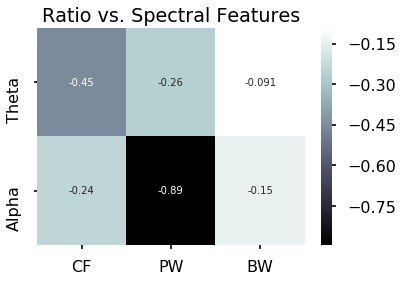

The corr of TAR to Exp is 0.18
The corr of TAR to Off is 0.19
The corr of TAR to Age is -0.37


<Figure size 432x288 with 0 Axes>

In [16]:
tar_per, tar_ap = param_ratio_corr(df, "TAR", ch_inds_parietal, func=nan_corr_spearman)
plot_param_ratio_corr(tar_per, y_labels=["Theta","Alpha"],save_fig=True, file_name="TAR_corrs")
print_aperiodic_correlation("TAR", tar_ap)

# ABR

### Global

SpearmanrResult(correlation=-0.26442608075376944, pvalue=2.272494483416143e-165)
SpearmanrResult(correlation=-0.08412540922672725, pvalue=9.209100975779661e-18)
SpearmanrResult(correlation=0.0018067572817925632, pvalue=0.8540750579070814)
SpearmanrResult(correlation=-0.2550372798950505, pvalue=9.561665489959044e-154)
SpearmanrResult(correlation=0.00876276566922399, pvalue=0.3723742688808912)
SpearmanrResult(correlation=-0.1152939026308864, pvalue=4.831251619175502e-32)
SpearmanrResult(correlation=0.7284222555134583, pvalue=0.0)
SpearmanrResult(correlation=0.6730206898089981, pvalue=0.0)
SpearmanrResult(correlation=-0.6089315099546881, pvalue=0.0)


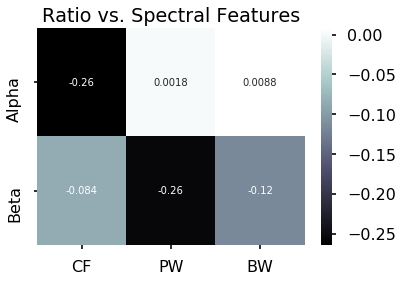

The corr of ABR to Exp is 0.73
The corr of ABR to Off is 0.67
The corr of ABR to Age is -0.61


<Figure size 432x288 with 0 Axes>

In [17]:
abr_per, abr_ap = param_ratio_corr(df, "ABR", all_chans, func=nan_corr_spearman)
plot_param_ratio_corr(abr_per, y_labels=["Alpha","Beta"],save_fig=True, file_name="ABR_corrs")
print_aperiodic_correlation("ABR", abr_ap)

### Frontal

SpearmanrResult(correlation=-0.26281908367427803, pvalue=8.736635161650534e-09)
SpearmanrResult(correlation=-0.07664352112384894, pvalue=0.09663649271896395)
SpearmanrResult(correlation=0.010555958695164395, pvalue=0.820407515992206)
SpearmanrResult(correlation=-0.32689492168568157, pvalue=3.427048433555829e-13)
SpearmanrResult(correlation=0.005940270394123491, pvalue=0.8983456251057095)
SpearmanrResult(correlation=-0.12406209496500632, pvalue=0.007023475825915103)
SpearmanrResult(correlation=0.7123548301930058, pvalue=2.7105688814659762e-76)
SpearmanrResult(correlation=0.6547698162506036, pvalue=1.0492076011873656e-60)
SpearmanrResult(correlation=-0.5704264478434629, pvalue=3.3000472047927283e-43)


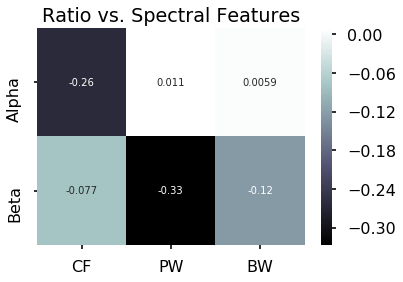

The corr of ABR to Exp is 0.71
The corr of ABR to Off is 0.65
The corr of ABR to Age is -0.57


<Figure size 432x288 with 0 Axes>

In [18]:
abr_per, abr_ap = param_ratio_corr(df, "ABR", ch_inds_frontal, func=nan_corr_spearman)
plot_param_ratio_corr(abr_per, y_labels=["Alpha","Beta"],save_fig=True, file_name="ABR_corrs")
print_aperiodic_correlation("ABR", abr_ap)

### Central

SpearmanrResult(correlation=-0.18116813373744606, pvalue=7.818207899798797e-05)
SpearmanrResult(correlation=-0.11630541433418815, pvalue=0.012847631817849894)
SpearmanrResult(correlation=0.053521157690917386, pvalue=0.2468430256504205)
SpearmanrResult(correlation=-0.15259715440551158, pvalue=0.0010663657815791)
SpearmanrResult(correlation=-0.03567884537249162, pvalue=0.44030104352685284)
SpearmanrResult(correlation=-0.13829546765586742, pvalue=0.0030508198431254286)
SpearmanrResult(correlation=0.7871623778262782, pvalue=1.3359844146248706e-102)
SpearmanrResult(correlation=0.7289061084704237, pvalue=7.5250488094932e-81)
SpearmanrResult(correlation=-0.6430942260735631, pvalue=1.7367703702374113e-57)


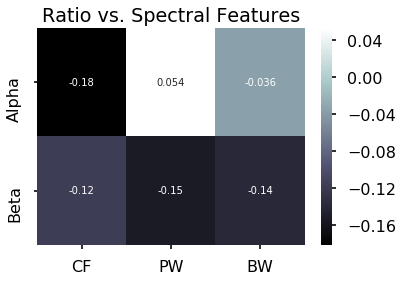

The corr of ABR to Exp is 0.79
The corr of ABR to Off is 0.73
The corr of ABR to Age is -0.64


<Figure size 432x288 with 0 Axes>

In [19]:
abr_per, abr_ap = param_ratio_corr(df, "ABR", ch_inds_central, func=nan_corr_spearman)
plot_param_ratio_corr(abr_per, y_labels=["Alpha","Beta"],save_fig=True, file_name="ABR_corrs")
print_aperiodic_correlation("ABR", abr_ap)

### Parietal

In [20]:
abr_ap

array([ 0.78716238,  0.72890611, -0.64309423])

In [21]:
tbr_ap

array([ 0.73808458,  0.73492072, -0.62997856])

SpearmanrResult(correlation=-0.34538176363983, pvalue=1.2154857158825953e-14)
SpearmanrResult(correlation=-0.10340524354395912, pvalue=0.024973306072937847)
SpearmanrResult(correlation=-0.04877262777327322, pvalue=0.29082854261909313)
SpearmanrResult(correlation=-0.35112176518911653, pvalue=4.40036051326251e-15)
SpearmanrResult(correlation=0.037734375545075693, pvalue=0.4139018225570993)
SpearmanrResult(correlation=-0.22995855708581273, pvalue=4.6600714809116796e-07)
SpearmanrResult(correlation=0.73808458370045, pvalue=1.024662051611738e-83)
SpearmanrResult(correlation=0.7349207244823109, pvalue=1.1739089289789453e-82)
SpearmanrResult(correlation=-0.6299785602500033, pvalue=1.901110886797472e-54)


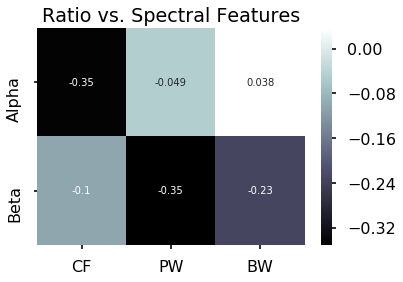

The corr of ABR to Exp is 0.74
The corr of ABR to Off is 0.73
The corr of ABR to Age is -0.63


<Figure size 432x288 with 0 Axes>

In [22]:
abr_per, abr_ap = param_ratio_corr(df, "ABR", ch_inds_parietal, func=nan_corr_spearman)
plot_param_ratio_corr(abr_per, y_labels=["Alpha","Beta"],save_fig=True, file_name="ABR_corrs")
print_aperiodic_correlation("ABR", abr_ap)

# Correlation between Ratios and Peak Parameters

# Single Channel
Here we will use Cz (index 94) across all participants

In [23]:
# Data Settings
cur_channel = "94"
cur_ratio = 'TAR'

In [24]:
#DataFrame which only has Cz channels
df_ch = df.loc[df['Chan_ID'] == cur_channel]

cz_exp = df.Exp.values.astype(float)
cz_age = df.Age.values.astype(float)
cz_ratio = df[cur_ratio].values.astype(float)

C:\Users\julio\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


### CZ: Exp to Age

In [43]:
print("The corr of {} to {} at {} is {:1.2f}, {:1.2f}".format('TAR', 'EXP', 'Cz', 0.500000000001, 0.01))

The corr of TAR to EXP at Cz is 0.50, 0.01


In [34]:
cz_exp_age_p = pearsonr(cz_exp, cz_age)
cz_exp_age_s = spearmanr(cz_exp, cz_age)

print("Cz exp->age pear:", cz_exp_age_p)
print("Cz exp->age spear:", cz_exp_age_s)

Cz exp->age pear: (-0.5733730602654656, 0.0)
Cz exp->age spear: SpearmanrResult(correlation=-0.6360477217326502, pvalue=0.0)


### CZ: TBR to Age

In [35]:
cz_tar_age_p = pearsonr(cz_tar, cz_age)
cz_tar_age_s = spearmanr(cz_tar, cz_age)

print("Cz tbr->age pear:", cz_tar_age_p)
print("Cz tbr->age spear:", cz_tar_age_s)

Cz tbr->age pear: (-0.2062977954036027, 4.920804533483743e-103)
Cz tbr->age spear: SpearmanrResult(correlation=-0.3128364612419722, pvalue=3.111147788583773e-241)


In [6]:
all_age_parietal = get_real_params(data, ch_inds_parietal)
all_age_central = get_real_params(data, ch_inds_central)
all_age_frontal = get_real_params(data, ch_inds_frontal)

###################

all_age_parietal_tb_ratio = all_age_parietal[0][0]
all_age_parietal_apc = all_age_parietal[0][1]

all_age_central_tb_ratio = all_age_central[0][0]
all_age_central_apc = all_age_central[0][1]

all_age_frontal_tb_ratio = all_age_frontal[0][0]
all_age_frontal_apc = all_age_frontal[0][1]

###################

all_age_parietal_pearson = pearsonr(all_age_parietal_apc, all_age_parietal_tb_ratio)
all_age_parietal_spearman = spearmanr(all_age_parietal_apc, all_age_parietal_tb_ratio)

all_age_central_pearson = pearsonr(all_age_central_apc, all_age_central_tb_ratio)
all_age_central_spearman = spearmanr(all_age_central_apc, all_age_central_tb_ratio)

all_age_frontal_pearson = pearsonr(all_age_frontal_apc, all_age_frontal_tb_ratio)
all_age_frontal_spearman = spearmanr(all_age_frontal_apc, all_age_frontal_tb_ratio)

NameError: name 'get_real_params' is not defined

# Peak param correlations below

In [5]:
all_age_parietal_fg = get_real_fg(data, ch_inds_parietal)
all_age_central_fg = get_real_fg(data, ch_inds_central)
all_age_frontal_fg = get_real_fg(data, ch_inds_frontal)

NameError: name 'ch_inds_parietal' is not defined

In [ ]:
for ind, val in enumerate(all_age_parietal_fg[0]):
    theta_cf_parietal.append(all_age_parietal_fg[0][ind].peak_params_[0][0])
    beta_cf_parietal.append(all_age_parietal_fg[0][ind].peak_params_[1][0])
    theta_amp_parietal.append(all_age_parietal_fg[0][ind].peak_params_[0][1])
    beta_amp_parietal.append(all_age_parietal_fg[0][ind].peak_params_[1][1])
    theta_bw_parietal.append(all_age_parietal_fg[0][ind].peak_params_[0][2])
    beta_bw_parietal.append(all_age_parietal_fg[0][ind].peak_params_[1][2])
    
    theta_cf_central.append(all_age_central_fg[0][ind].peak_params_[0][0])
    beta_cf_central.append(all_age_central_fg[0][ind].peak_params_[1][0])
    theta_amp_central.append(all_age_central_fg[0][ind].peak_params_[0][1])
    beta_amp_central.append(all_age_central_fg[0][ind].peak_params_[1][1])
    theta_bw_central.append(all_age_central_fg[0][ind].peak_params_[0][2])
    beta_bw_central.append(all_age_central_fg[0][ind].peak_params_[1][2])
    
    theta_cf_frontal.append(all_age_frontal_fg[0][ind].peak_params_[0][0])
    beta_cf_frontal.append(all_age_frontal_fg[0][ind].peak_params_[1][0])
    theta_amp_frontal.append(all_age_frontal_fg[0][ind].peak_params_[0][1])
    beta_amp_frontal.append(all_age_frontal_fg[0][ind].peak_params_[1][1])
    theta_bw_frontal.append(all_age_frontal_fg[0][ind].peak_params_[0][2])
    beta_bw_frontal.append(all_age_frontal_fg[0][ind].peak_params_[1][2])
avg_tb_ratios = all_age_parietal_fg[1]

In [106]:
# Theta CF Parietal
parietal_t_cf_pear = nan_corr_p(theta_cf_parietal, avg_tb_ratios)
parietal_t_cf_spear = nan_corr_s(theta_cf_parietal, avg_tb_ratios)

# Beta CF Parietal
parietal_b_cf_pear = nan_corr_p(beta_cf_parietal, avg_tb_ratios)
parietal_b_cf_spear = nan_corr_s(beta_cf_parietal, avg_tb_ratios)

#Theta amp parietal
parietal_t_amp_pear = nan_corr_p(theta_amp_parietal, avg_tb_ratios)
parietal_t_amp_spear = nan_corr_s(theta_amp_parietal, avg_tb_ratios)

# beta amp parietal
parietal_b_amp_pear = nan_corr_p(beta_amp_parietal, avg_tb_ratios)
parietal_b_amp_spear = nan_corr_s(beta_amp_parietal, avg_tb_ratios)

#theta bw parietal
parietal_t_bw_pear = nan_corr_p(theta_bw_parietal, avg_tb_ratios)
parietal_t_bw_spear = nan_corr_s(theta_bw_parietal, avg_tb_ratios)

#beta bw parietal
parietal_b_bw_pear = nan_corr_p(beta_bw_parietal, avg_tb_ratios)
parietal_b_bw_spear = nan_corr_s(beta_bw_parietal, avg_tb_ratios)

################################################

# Theta CF central
central_t_cf_pear = nan_corr_p(theta_cf_central, avg_tb_ratios)
central_t_cf_spear = nan_corr_s(theta_cf_central, avg_tb_ratios)

# Beta CF Parietal
central_b_cf_pear = nan_corr_p(beta_cf_central, avg_tb_ratios)
central_b_cf_spear = nan_corr_s(beta_cf_central, avg_tb_ratios)

#Theta amp parietal
central_t_amp_pear = nan_corr_p(theta_amp_central, avg_tb_ratios)
central_t_amp_spear = nan_corr_s(theta_amp_central, avg_tb_ratios)

# beta amp parietal
central_b_amp_pear = nan_corr_p(beta_amp_central, avg_tb_ratios)
central_b_amp_spear = nan_corr_s(beta_amp_central, avg_tb_ratios)

#theta bw parietal
central_t_bw_pear = nan_corr_p(theta_bw_central, avg_tb_ratios)
central_t_bw_spear = nan_corr_s(theta_bw_central, avg_tb_ratios)

#beta bw parietal
central_b_bw_pear = nan_corr_p(beta_bw_central, avg_tb_ratios)
central_b_bw_spear = nan_corr_s(beta_bw_central, avg_tb_ratios)

################################################
# Theta CF central
frontal_t_cf_pear = nan_corr_p(theta_cf_frontal, avg_tb_ratios)
frontal_t_cf_spear = nan_corr_s(theta_cf_frontal, avg_tb_ratios)

# Beta CF Parietal
frontal_b_cf_pear = nan_corr_p(beta_cf_frontal, avg_tb_ratios)
frontal_b_cf_spear = nan_corr_s(beta_cf_frontal, avg_tb_ratios)

#Theta amp parietal
frontal_t_amp_pear = nan_corr_p(theta_amp_frontal, avg_tb_ratios)
frontal_t_amp_spear = nan_corr_s(theta_amp_frontal, avg_tb_ratios)

# beta amp parietal
frontal_b_amp_pear = nan_corr_p(beta_amp_frontal, avg_tb_ratios)
frontal_b_amp_spear = nan_corr_s(beta_amp_frontal, avg_tb_ratios)

#theta bw parietal
frontal_t_bw_pear = nan_corr_p(theta_bw_frontal, avg_tb_ratios)
frontal_t_bw_spear = nan_corr_s(theta_bw_frontal, avg_tb_ratios)

#beta bw parietal
frontal_b_bw_pear = nan_corr_p(beta_bw_frontal, avg_tb_ratios)
frontal_b_bw_spear = nan_corr_s(beta_bw_frontal, avg_tb_ratios)

In [140]:
print("central theta cf spearman: " ,central_t_cf_spear)
print("central theta amp spearman: " ,central_t_amp_spear)
print("central theta bw spearman: " ,central_t_bw_spear)

print("central beta cf spearman: " ,central_b_cf_spear)
print("central beta amp spearman: " ,central_b_amp_spear)
print("central beta bw spearman: " ,central_b_bw_spear)
theta_data = [central_t_cf_spear[0],central_t_amp_spear[0], central_t_bw_spear[0]]
beta_data = [central_b_cf_spear[0],central_b_amp_spear[0], central_b_bw_spear[0]]
heats = np.array([theta_data, beta_data])

central theta cf spearman:  SpearmanrResult(correlation=-0.0002908483921142149, pvalue=0.9979835636736129)
central theta amp spearman:  SpearmanrResult(correlation=0.2869409071940717, pvalue=0.010862745523717)
central theta bw spearman:  SpearmanrResult(correlation=0.25806904209266446, pvalue=0.022536902721927647)
central beta cf spearman:  SpearmanrResult(correlation=0.03506995581737849, pvalue=0.7330837766115756)
central beta amp spearman:  SpearmanrResult(correlation=-0.27132863454660217, pvalue=0.0071825001951504736)
central beta bw spearman:  SpearmanrResult(correlation=-0.1242837559303342, pvalue=0.22517042716138022)


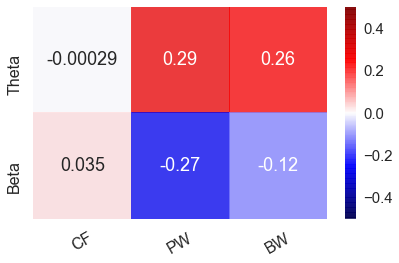

In [188]:

fig, ax = plt.subplots()


# We want to show all ticks...

# ... and label them with the respective list entries

ax.set_yticklabels(["theta", "beta"])

sns.set(font_scale=1.5)

sns.heatmap(heats, vmin=-.5,vmax=.5,annot=True, cmap= "seismic", xticklabels=["CF", "PW", "BW"], yticklabels=["Theta","Beta"], alpha=.75)
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("../figures/spectral_features_corr_to_TBR.png", dpi=700)

## Aperiodic stuff below

In [39]:
# Exponenent


# Peak Params
#fm_parietal = avg_fg(all_age_parietal_fg[0])
#fm_central = avg_fg(all_age_central_fg[0])
#fm_frontal = avg_fg(all_age_frontal_fg[0])

In [ ]:


print("All subjects parietal pearson: ", all_age_parietal_pearson)
print("All subjects parietal spearman: ", all_age_parietal_spearman)
print(" ")

print("All subjects central pearson: ", all_age_central_pearson)
print("All subjects central spearman: ", all_age_central_spearman)
print(" ")

print("All subjects frontal pearson: ", all_age_frontal_pearson)
print("All subjects frontal spearman: ", all_age_frontal_spearman)
print(" ")

## Predicting age from exponent

In [45]:
all_age_parietal_exp_age_p = pearsonr(all_age_parietal_apc, all_age_parietal[0][3])
all_age_parietal_exp_age_s = spearmanr(all_age_parietal_apc, all_age_parietal[0][3])

all_age_frontal_exp_age_p = pearsonr(all_age_frontal_apc, all_age_frontal[0][3])
all_age_frontal_exp_age_s = spearmanr(all_age_frontal_apc, all_age_frontal[0][3])

all_age_central_exp_age_p = pearsonr(all_age_central_apc, all_age_central[0][3])
all_age_central_exp_age_s = spearmanr(all_age_central_apc, all_age_central[0][3])

print("parietal exponent correlates to age (pearson): ", all_age_parietal_exp_age_p)
print("parietal exponent correlates to age (spearman): ", all_age_parietal_exp_age_s)
print()

print("frontal exponent correlates to age (pearson): ", all_age_frontal_exp_age_p)
print("frontal exponent correlates to age (spearman): ", all_age_frontal_exp_age_s)
print()

print("central exponent correlates to age (pearson): ", all_age_central_exp_age_p)
print("central exponent correlates to age (spearman): ", all_age_central_exp_age_s)

parietal exponent correlates to age (pearson):  (-0.6346683381968523, 4.876675414400836e-56)
parietal exponent correlates to age (spearman):  SpearmanrResult(correlation=-0.6872611745253143, pvalue=4.704989892502931e-69)

frontal exponent correlates to age (pearson):  (-0.5763808342149647, 2.7991407815194255e-44)
frontal exponent correlates to age (spearman):  SpearmanrResult(correlation=-0.6682322088698998, pvalue=4.8991535403989085e-64)

central exponent correlates to age (pearson):  (-0.5224239758370124, 2.5732584232546035e-35)
central exponent correlates to age (spearman):  SpearmanrResult(correlation=-0.6214873474536138, pvalue=3.6765509885372348e-53)


## Predicting Age from TBR

In [47]:
all_age_parietal_tbr_age_p = pearsonr(all_age_parietal_tb_ratio, all_age_parietal[0][3])
all_age_parietal_tbr_age_s = spearmanr(all_age_parietal_tb_ratio, all_age_parietal[0][3])

all_age_frontal_tbr_age_p = pearsonr(all_age_frontal_tb_ratio, all_age_frontal[0][3])
all_age_frontal_tbr_age_s = spearmanr(all_age_frontal_tb_ratio, all_age_frontal[0][3])

all_age_central_tbr_age_p = pearsonr(all_age_central_tb_ratio, all_age_central[0][3])
all_age_central_tbr_age_s = spearmanr(all_age_central_tb_ratio, all_age_central[0][3])

print("parietal exponent correlates to age (pearson): ", all_age_parietal_tbr_age_p)
print("parietal exponent correlates to age (spearman): ", all_age_parietal_tbr_age_s)
print()

print("frontal exponent correlates to age (pearson): ", all_age_frontal_tbr_age_p)
print("frontal exponent correlates to age (spearman): ", all_age_frontal_tbr_age_s)
print()

print("central exponent correlates to age (pearson): ", all_age_central_tbr_age_p)
print("central exponent correlates to age (spearman): ", all_age_central_tbr_age_s)

parietal exponent correlates to age (pearson):  (-0.4670253733105622, 1.206598334508968e-27)
parietal exponent correlates to age (spearman):  SpearmanrResult(correlation=-0.6367548776477613, pvalue=1.6586917847631905e-56)

frontal exponent correlates to age (pearson):  (-0.4465835155636714, 3.7701086519872125e-25)
frontal exponent correlates to age (spearman):  SpearmanrResult(correlation=-0.5833603215560321, pvalue=1.454751633682585e-45)

central exponent correlates to age (pearson):  (-0.48649966838431596, 3.4930650277180965e-30)
central exponent correlates to age (spearman):  SpearmanrResult(correlation=-0.6507169948479196, pvalue=9.782106424394115e-60)


In [ ]:
plt.scatter(df["ABR"],df["Alpha_PW"])
pd.plotting.scatter_matrix(df[['TAR', 'Alpha_CF', 'Alpha_PW', 'Alpha_BW']]);